In [1]:
import os 
import sys
import argparse
import evolocity as evo
import anndata
import pandas as pd
import numpy as np
import torch
import scanpy as sc
import plotly.express as px


In [2]:
dataset = "horns2020a__VDJ_RAW"
mode = "full_VDJ"

### Mimicking Clonal Evolution

In [3]:
import pandas as pd

sys.path.append("../src")

from ablang_model import Ablang
from antiberty_model import Antiberty
from ESM_model import ESM
from sapiens_model import Sapiens
from protbert import ProtBert

if not os.path.exists(os.path.join("..","..","..","data",dataset,"clonal_sub_rank_table.csv")):
    model_names = ["ablang","protbert","sapiens","ESM"]
    model_classes = [Ablang,ProtBert, Sapiens,ESM]
    
    abforest_files_location = os.path.join("..","..","..","data",dataset,"clonal_analysis")
    
    output_table = []
    
    file_names = os.listdir(abforest_files_location)
    
    node_features_filename = [file_name for file_name in file_names if ("node_features" in file_name)]
    adj_mat_filename = [file_name for file_name in file_names if ("adj_mat" in file_name)]
    
    node_features_filename = node_features_filename[0]
    adj_mat_filename = adj_mat_filename[0]
    
    for j,model in enumerate(model_names):
        
        torch.cuda.empty_cache()
        
        all_node_features = pd.read_csv(os.path.join(abforest_files_location, node_features_filename))
        all_adj_mat = pd.read_csv(os.path.join(abforest_files_location, adj_mat_filename))
        
        clonotypes = list(all_node_features["sample_clonotype"].unique())
        
        if model == "ablang":
            model_init = Ablang(chain="heavy")
        if model == "sapiens":
            model_init = Sapiens(chain_type="H")
        else:
            model_init = model_classes[j]()
    
        for clonotype in clonotypes:
                    
            node_features = all_node_features.loc[all_node_features["sample_clonotype"] == clonotype,:]
            adj_mat = all_adj_mat.loc[all_adj_mat["sample_clonotype"] == clonotype,:]
    
            germline_index = node_features["label"].astype(int).max()
            
            node_features = node_features.loc[node_features["label"] != germline_index, :].reset_index(drop = True)
            adj_mat = adj_mat.loc[adj_mat["i"] != germline_index,:].reset_index(drop = True)
            
            num_edges = adj_mat.shape[0]
        
            for i in range(adj_mat.shape[0]):
                
                seq_2 = node_features["network_sequences"][adj_mat.iloc[i,0] - 1]
                seq_1 = node_features["network_sequences"][adj_mat.iloc[i,1] - 1]
    
                if len(seq_1) != len(seq_2):
                    continue
    
                diff_positions = [k for k in range(len(seq_1)) if seq_1[k] != seq_2[k]]
                same_positions = list(set(range(len(seq_1))) - set(diff_positions))
                
                prob_matrix = model_init.calc_probability_matrix(seq_1)
                
                substitute_ranks = []
                unmutated_ranks = []
                unmutated_pos_ranks = []
    
                substitute_probs = []
                unmutated_probs = []
                unmutated_pos_probs = []
                
                for pos in diff_positions:
    
                    likelihood_values = pd.Series(prob_matrix.iloc[pos,:])
                    ranks = likelihood_values.rank(ascending=False)
    
                    substitute_ranks.append(ranks[seq_2[pos]])
                    unmutated_ranks.append(ranks[seq_1[pos]])
    
                    substitute_probs.append(likelihood_values[seq_2[pos]])
                    unmutated_probs.append(likelihood_values[seq_1[pos]])
    
                for pos in same_positions:
    
                    likelihood_values = pd.Series(prob_matrix.iloc[pos,:])
                    ranks = likelihood_values.rank(ascending=False)
                    
                    unmutated_pos_ranks.append(ranks[seq_1[pos]])
                    unmutated_pos_probs.append(likelihood_values[seq_1[pos]])
    
                mean_substitute_rank = np.average(substitute_ranks)
                mean_unmutated_rank = np.average(unmutated_ranks)
                mean_unmutated_pos_rank = np.average(unmutated_pos_ranks)
    
                mean_substitute_probs = np.average(substitute_probs)
                mean_unmutated_probs = np.average(unmutated_probs)
                mean_unmutated_pos_probs = np.average(unmutated_pos_probs)
    
                output_table.append({"model":model,"clonotype":clonotype,"edge":f"edge_{i}","n_subs":len(diff_positions),
                                     "mean_sub_rank":mean_substitute_rank, "mean_unmutated_rank":mean_unmutated_rank,
                                    "mean_unmutated_pos_rank":mean_unmutated_pos_rank,"mean_substitute_probs":mean_substitute_probs,
                                    "mean_unmutated_probs":mean_unmutated_probs,"mean_unmutated_pos_probs":mean_unmutated_pos_probs})
    
        del(model_init)    
                
    output_table = pd.DataFrame(output_table)
else:
    output_table = pd.read_csv(os.path.join("..","..","..","data",dataset,"clonal_sub_rank_table_rev.csv"))

#### Mutated residues in mutating positions 

In [38]:
output_table

,model,clonotype,edge,n_subs,mean_sub_rank,mean_unmutated_rank,mean_unmutated_pos_rank,mean_substitute_probs,mean_unmutated_probs,mean_unmutated_pos_probs
0,ablang,s1_clonotype1,edge_0,18,4.111111,1.722222,1.021277,0.242657,0.567410,0.926657
1,ablang,s1_clonotype1,edge_1,12,3.500000,2.083333,1.020000,0.292385,0.430943,0.921478
2,ablang,s1_clonotype1,edge_3,16,3.062500,2.000000,1.104167,0.285423,0.483494,0.894153
3,ablang,s1_clonotype2,edge_0,3,5.666667,4.666667,1.925620,0.032352,0.333311,0.803585
4,ablang,s1_clonotype2,edge_1,3,5.666667,4.666667,1.925620,0.037808,0.283924,0.804809
...,...,...,...,...,...,...,...,...,...,...
379,ESM,s4_clonotype343,edge_0,1,2.000000,1.000000,1.271186,0.034242,0.938358,0.829873
380,ESM,s4_clonotype367,edge_0,3,1.666667,1.333333,1.034188,0.321354,0.676902,0.934669
381,ESM,s4_clonotype434,edge_0,2,12.500000,1.000000,1.050000,0.008296,0.727903,0.909778
382,ESM,s4_clonotype449,edge_0,1,3.000000,1.000000,1.172131,0.000148,0.999365,0.893606


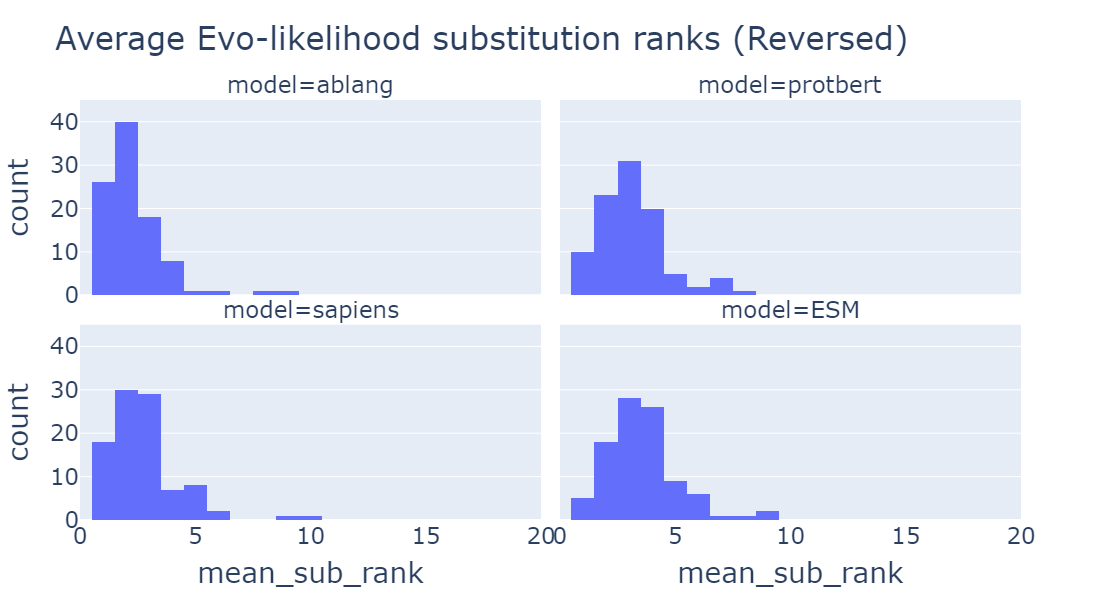

In [5]:
output_table_subset = output_table#.loc[(output_table["n_subs"] == 1),:]

fig = px.histogram(
    data_frame = output_table_subset,
    x = "mean_sub_rank",
    facet_col = "model",
    facet_col_wrap=2,
    orientation = "v",
    title=f' Average Evo-likelihood substitution ranks (Reversed)',
)

fig.update_traces(xbins_size=1)
fig.update_layout(height = 600, font_size = 23)
fig.update_xaxes(range=[0, 20])
fig.update_yaxes(range=[0, 45])

fig.show()

#### Unmutated residues in mutating positions

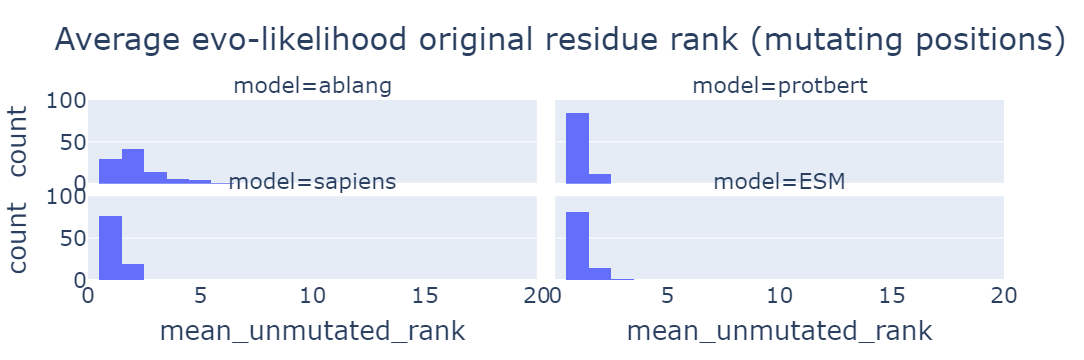

In [44]:
output_table_subset = output_table#.loc[(output_table["n_subs"] == 1),:]

fig = px.histogram(
    data_frame = output_table_subset,
    x = "mean_unmutated_rank",
    facet_col = "model",
    facet_col_wrap=2,
    orientation = "v",
    title=f'Average evo-likelihood original residue rank (mutating positions)',
)

fig.update_traces(xbins_size=1)
fig.update_layout(height = 600, font_size = 22)
fig.update_xaxes(range=[0, 20])
fig.update_yaxes(range=[0, 100])

fig.show()

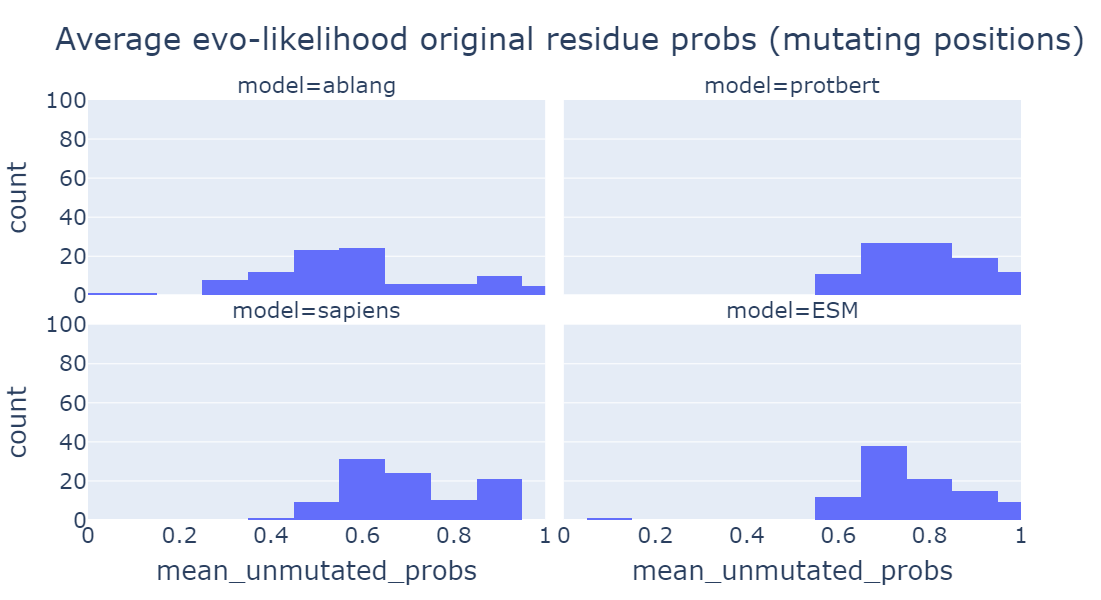

In [43]:
fig = px.histogram(
    data_frame = output_table_subset,
    x = "mean_unmutated_probs",
    facet_col = "model",
    facet_col_wrap=2,
    orientation = "v",
    title=f'Average evo-likelihood original residue probs (mutating positions)',
)

fig.update_traces(xbins_size=0.1)
fig.update_layout(height = 600, font_size = 22)
fig.update_xaxes(range=[0, 1])
fig.update_yaxes(range=[0, 100])

fig.show()

#### Unmutated residues in conserved positions

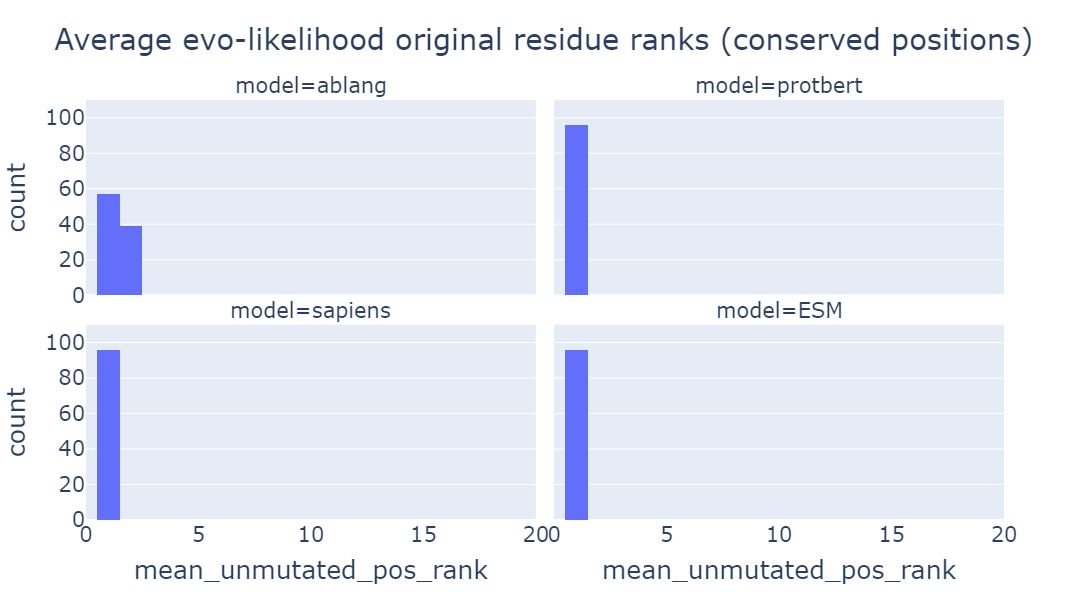

In [42]:
output_table_subset = output_table#.loc[(output_table["n_subs"] == 1),:]

fig = px.histogram(
    data_frame = output_table_subset,
    x = "mean_unmutated_pos_rank",
    facet_col = "model",
    facet_col_wrap=2,
    orientation = "v",
    title=f'Average evo-likelihood original residue ranks (conserved positions)',
)

fig.update_traces(xbins_size=1)
fig.update_layout(height = 600, font_size = 21)
fig.update_xaxes(range=[0, 20])
fig.update_yaxes(range=[0, 110])

fig.show()

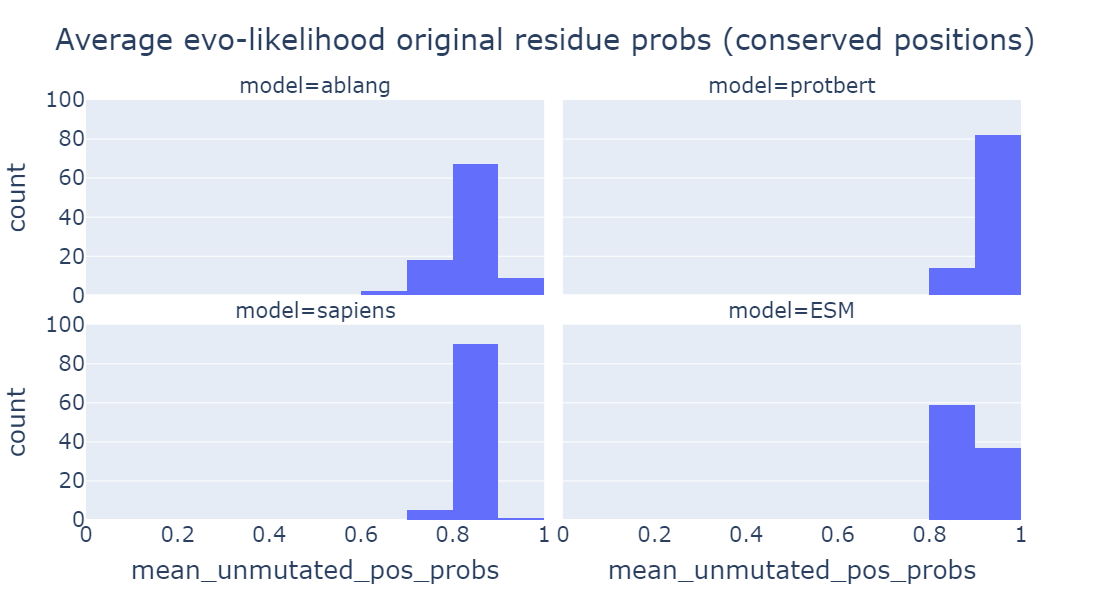

In [41]:
output_table_subset = output_table#.loc[(output_table["n_subs"] == 1),:]

fig = px.histogram(
    data_frame = output_table_subset,
    x = "mean_unmutated_pos_probs",
    facet_col = "model",
    facet_col_wrap=2,
    orientation = "v",
    title=f'Average evo-likelihood original residue probs (conserved positions)',
)

fig.update_traces(xbins_size=0.1)
fig.update_layout(height = 600, font_size = 21)
fig.update_xaxes(range=[0, 1])
fig.update_yaxes(range=[0, 100])

fig.show()